In [17]:
!pip install keras-tuner
!pip install tensorflow_addons
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import tensorflow_addons as tfa

In [18]:
import tensorflow as tf
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [19]:
#Importing Input data
data_cohesion = np.load('Inputs/4ft_cohesion.npy')
data_friction = np.load('Inputs/4ft_friction.npy')
data_poly = np.load('Inputs/4ft_poly_feature.npy')
data_watertable = np.load('Inputs/4ft_water_table.npy')
data_velo = np.load("Targets/4ft_velocity_plots.npy")
data_watertable = np.squeeze(data_watertable)

In [20]:
#Size
data_cohesion = np.transpose(data_cohesion)
data_friction = np.transpose(data_friction)
data_watertable = np.transpose(data_watertable)
data_watertable = np.squeeze(data_watertable)
print(np.shape(data_cohesion))
print(np.shape(data_friction))
print(np.shape(data_watertable))
print(np.shape(data_velo))
m = np.shape(data_cohesion)[1]
n_sim = np.shape(data_velo)[2]
n_final_test = 0
n_remain = n_sim - n_final_test
mo = np.shape(data_velo)[0]

(144807, 16)
(144807, 16)
(144807,)
(33, 33, 144807)


In [21]:
li= []
for i in range (n_sim):
    temp = np.reshape(data_velo[:,:,i],(mo*mo,1))
    li.append(temp)
data = np.array(li)

In [22]:
data_arr= np.zeros((n_remain,2*m + 1))
data_arr[0:n_remain,0:m] = data_cohesion[0:n_remain,:]
data_arr[0:n_remain,m:2*m] = data_friction[0:n_remain,:]
data_arr[0:n_remain,2*m] = data_watertable[0:n_remain]

In [23]:
data_x = data_arr
data_y = data[0:n_remain,:,:]
data_y = np.reshape(data_y, (n_remain,mo*mo))

In [24]:
data_y1 = np.zeros((np.shape(data_y)))
for i in range(n_sim):
    data_y1[i,:] = data_y[i,:]/np.max(data_y[i,:])

In [25]:
np.shape(data_y1)

(144807, 1089)

In [26]:
np.shape(data_arr)

(144807, 33)

In [27]:
def build_model(hp):
    
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 3, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=512,
                                            max_value=4068,
                                            step=64),
                               activation='relu'))
    model.add(layers.Dense(1089, activation='linear'))
    metric = tfa.metrics.r_square.RSquare()
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=[metric])
    return model

In [28]:
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='Velocity Field')

INFO:tensorflow:Reloading Oracle from existing project project\Velocity Field\oracle.json


In [29]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 4068, 'step': 64, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 4068, 'step': 64, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 4068, 'step': 64, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y1, test_size=0.1, random_state = 42)
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

In [37]:
tuner.search(x_train, y_train,
             epochs=100,
             validation_data=(x_test, y_test))


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
6                 |?                 |num_layers
1920              |?                 |units_0
3328              |?                 |units_1
1856              |?                 |units_2
0.001             |?                 |learning_rate
512               |?                 |units_3
512               |?                 |units_4
512               |?                 |units_5

Epoch 1/100
4073/4073 [==============================] - 32s 8ms/step - loss: 0.0519 - r_square: 0.1310 - val_loss: 0.0425 - val_r_square: 0.3386
Epoch 2/100
4073/4073 [==============================] - 31s 8ms/step - loss: 0.0387 - r_square: 0.4254 - val_loss: 0.0359 - val_r_square: 0.4596
Epoch 3/100
4073/4073 [==============================] - 31s 8ms/step - loss: 0.0340 - r_square: 0.5112 - val_loss: 0.0335 - val_r_square: 0.5229
Epoch 4/100
4073/4073 [==============================] - 31s 8ms/step - loss: 0.0313 - r_square: 0.5540 

4073/4073 [==============================] - 32s 8ms/step - loss: 0.0175 - r_square: 0.7353 - val_loss: 0.0220 - val_r_square: 0.6407
Epoch 54/100
4073/4073 [==============================] - 35s 8ms/step - loss: 0.0174 - r_square: 0.7373 - val_loss: 0.0226 - val_r_square: 0.6446
Epoch 55/100
4073/4073 [==============================] - 33s 8ms/step - loss: 0.0174 - r_square: 0.7371 - val_loss: 0.0218 - val_r_square: 0.6340
Epoch 56/100
4073/4073 [==============================] - 34s 8ms/step - loss: 0.0173 - r_square: 0.7385 - val_loss: 0.0218 - val_r_square: 0.6428
Epoch 57/100
4073/4073 [==============================] - 34s 8ms/step - loss: 0.0174 - r_square: 0.7372 - val_loss: 0.0221 - val_r_square: 0.6367
Epoch 58/100
4073/4073 [==============================] - 34s 8ms/step - loss: 0.0172 - r_square: 0.7414 - val_loss: 0.0219 - val_r_square: 0.6301
Epoch 59/100
4073/4073 [==============================] - 34s 8ms/step - loss: 0.0172 - r_square: 0.7405 - val_loss: 0.0220 - val_r

4073/4073 [==============================] - 35s 9ms/step - loss: 0.0270 - r_square: 0.6053 - val_loss: 0.0282 - val_r_square: 0.5782
Epoch 8/100
4073/4073 [==============================] - 35s 9ms/step - loss: 0.0262 - r_square: 0.6162 - val_loss: 0.0272 - val_r_square: 0.5951
Epoch 9/100
4073/4073 [==============================] - 35s 9ms/step - loss: 0.0254 - r_square: 0.6268 - val_loss: 0.0270 - val_r_square: 0.5928
Epoch 10/100
4073/4073 [==============================] - 35s 9ms/step - loss: 0.0247 - r_square: 0.6354 - val_loss: 0.0268 - val_r_square: 0.5762
Epoch 11/100
4073/4073 [==============================] - 35s 9ms/step - loss: 0.0241 - r_square: 0.6436 - val_loss: 0.0258 - val_r_square: 0.5922
Epoch 12/100
4073/4073 [==============================] - 35s 9ms/step - loss: 0.0236 - r_square: 0.6500 - val_loss: 0.0258 - val_r_square: 0.6104
Epoch 13/100
4073/4073 [==============================] - 35s 9ms/step - loss: 0.0232 - r_square: 0.6544 - val_loss: 0.0257 - val_r_s

Epoch 63/100
4073/4073 [==============================] - 35s 9ms/step - loss: 0.0172 - r_square: 0.7326 - val_loss: 0.0220 - val_r_square: 0.6423
Epoch 64/100
4073/4073 [==============================] - 35s 8ms/step - loss: 0.0173 - r_square: 0.7312 - val_loss: 0.0226 - val_r_square: 0.6216
Epoch 65/100
4073/4073 [==============================] - 35s 8ms/step - loss: 0.0171 - r_square: 0.7345 - val_loss: 0.0225 - val_r_square: 0.6171
Epoch 66/100
4073/4073 [==============================] - 34s 8ms/step - loss: 0.0171 - r_square: 0.7358 - val_loss: 0.0231 - val_r_square: 0.6401
Epoch 67/100
4073/4073 [==============================] - 34s 8ms/step - loss: 0.0170 - r_square: 0.7355 - val_loss: 0.0226 - val_r_square: 0.6308
Epoch 68/100
4073/4073 [==============================] - 34s 8ms/step - loss: 0.0169 - r_square: 0.7365 - val_loss: 0.0223 - val_r_square: 0.6206
Epoch 69/100
4073/4073 [==============================] - 34s 8ms/step - loss: 0.0167 - r_square: 0.7395 - val_loss: 0

Epoch 17/100
4073/4073 [==============================] - 37s 9ms/step - loss: 0.0215 - r_square: 0.6755 - val_loss: 0.0239 - val_r_square: 0.6250
Epoch 18/100
4073/4073 [==============================] - 38s 9ms/step - loss: 0.0213 - r_square: 0.6770 - val_loss: 0.0238 - val_r_square: 0.6130
Epoch 19/100
4073/4073 [==============================] - 37s 9ms/step - loss: 0.0211 - r_square: 0.6821 - val_loss: 0.0237 - val_r_square: 0.5944
Epoch 20/100
4073/4073 [==============================] - 36s 9ms/step - loss: 0.0209 - r_square: 0.6835 - val_loss: 0.0232 - val_r_square: 0.6381
Epoch 21/100
4073/4073 [==============================] - 36s 9ms/step - loss: 0.0207 - r_square: 0.6868 - val_loss: 0.0234 - val_r_square: 0.6121
Epoch 22/100
4073/4073 [==============================] - 33s 8ms/step - loss: 0.0204 - r_square: 0.6908 - val_loss: 0.0232 - val_r_square: 0.6293
Epoch 23/100
4073/4073 [==============================] - 35s 9ms/step - loss: 0.0203 - r_square: 0.6937 - val_loss: 0

Epoch 73/100
4073/4073 [==============================] - 33s 8ms/step - loss: 0.0167 - r_square: 0.7417 - val_loss: 0.0216 - val_r_square: 0.6416
Epoch 74/100
4073/4073 [==============================] - 34s 8ms/step - loss: 0.0165 - r_square: 0.7462 - val_loss: 0.0217 - val_r_square: 0.6371
Epoch 75/100
4073/4073 [==============================] - 33s 8ms/step - loss: 0.0167 - r_square: 0.7445 - val_loss: 0.0219 - val_r_square: 0.6303
Epoch 76/100
4073/4073 [==============================] - 33s 8ms/step - loss: 0.0165 - r_square: 0.7487 - val_loss: 0.0222 - val_r_square: 0.6461
Epoch 77/100
4073/4073 [==============================] - 33s 8ms/step - loss: 0.0166 - r_square: 0.7443 - val_loss: 0.0216 - val_r_square: 0.6402
Epoch 78/100
4073/4073 [==============================] - 33s 8ms/step - loss: 0.0164 - r_square: 0.7499 - val_loss: 0.0218 - val_r_square: 0.6468
Epoch 79/100
4073/4073 [==============================] - 34s 8ms/step - loss: 0.0165 - r_square: 0.7475 - val_loss: 0

KeyError: 'val_mae'

In [36]:
tuner.results_summary()

Results summary
Results in project\Velocity Field
Showing 10 best trials


In [11]:
y_pred = ann1.predict(x_test)
y_pred = sc.inverse_transform(y_pred)
y_actual = sc.inverse_transform(y_test)
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
r2 = r2_score(y_actual,y_pred)
r2

906/906 [==============================] - 2s 2ms/step


0.6543499371097048

In [12]:
np.shape(y_pred[0,:])

(1089,)

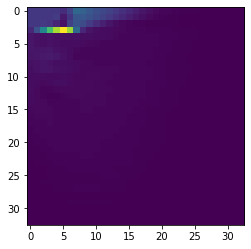

In [13]:
a = np.reshape(y_pred[0,:],(33,33))
plt.imshow(a)

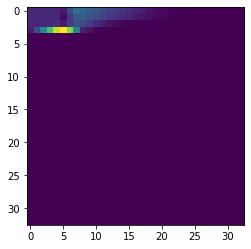

In [14]:
b = np.reshape(y_actual[0,:],(33,33))
plt.imshow(b)

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model